In [1]:
import cv2
from PIL import Image as PIL_Img
from IPython.display import Image, display
from leptonai.photon.types import lepton_pickle, lepton_unpickle
import os
import uuid
import requests
import numpy as np

import pandas as pd
import lancedb
uri = "data/sample-lancedb"
db = lancedb.connect(uri)

from leptonai.client import Client
LEPTON_API_TOKEN = "YOUR_LEPTON_API_TOKEN"

In [2]:
clip_client = Client("YOUR_WORKSPACE_ID", "CLIP_DEPLOYMENT_NAME", token=LEPTON_API_TOKEN)
sam_client = Client("YOUR_WORKSPACE_ID", "SAM_DEPLOYMENT_NAME", token=LEPTON_API_TOKEN)

In [3]:
def get_image_embeddings_from_path(file_path, client):
    input_img = cv2.imread(file_path)
    pickle_img = lepton_pickle(PIL_Img.fromarray(input_img), compression=9)
    return client.embed_pickle_image(image=pickle_img)

In [4]:
import uuid
import requests
import os

def download_image(url):
    response = requests.get(url)
    img_dir = uuid.uuid4().hex[:6]
    os.makedirs(img_dir)
    file_path = img_dir + '/' + 'index' + ".jpg"
    with open(file_path, "wb") as f:
        f.write(response.content)
    return img_dir



In [5]:
def get_image_result_from_pickle(img_path, sam_client):
    input_img = cv2.imread(img_path)
    pickle_img = lepton_pickle(PIL_Img.fromarray(input_img))
    return sam_client.seg_from_pickle(image=pickle_img)

In [6]:
def crop_image_by_seg(image, segmentation):
    '''
    Input:
        image: np.array,
        segmentation : np.array

    '''
    binary_mask = segmentation.astype(int)

    # Create a white canvas of the same size as the image
    white_canvas = np.ones_like(image) * 255

    # Apply the binary mask to the original image and white canvas
    cropped_image = np.where(binary_mask[..., None] > 0, image, white_canvas)
    return cropped_image

In [7]:
def crop_image_with_bbox(image, bbox):
    X,Y,W,H = bbox
    cropped_image = image[Y:Y+H, X:X+W]

    return cropped_image

In [8]:
def cut_image_to_embeddings_vdb(img_uuid):
    img_path = img_uuid + '/index.jpg'
    source_img = cv2.imread(img_path)
    segmentations = lepton_unpickle(get_image_result_from_pickle(img_path, sam_client))

    for index, seg in enumerate(segmentations):
        cropped_img = crop_image_with_bbox(crop_image_by_seg(source_img, seg['segmentation']), seg['bbox'])
        c_img_path = img_uuid + '/{}.jpg'.format(index)
        cv2.imwrite(c_img_path, cropped_img)
        embeddings = get_image_embeddings_from_path(c_img_path, clip_client)
        seg['embeddings'] = embeddings
        seg['img_path'] = c_img_path
        seg['seg_shape'] = seg['segmentation'].shape        
        seg['segmentation'] = seg['segmentation'].reshape(-1)


    seg_df = pd.DataFrame(segmentations)
    seg_df = seg_df[['img_path', 'embeddings', 'bbox', 'stability_score', 'predicted_iou', 'segmentation','seg_shape']]
    seg_df = seg_df.rename(columns={"embeddings": "vector"})
    tbl = db.create_table("table_{}".format(img_uuid), data=seg_df)
    return tbl

In [9]:
def find_part(vector_table, img_id, user_query):
    
    k_embedding = clip_client.embed_text(query=user_query)

    target = vector_table.search(k_embedding).limit(1).to_df()
    segmentation_mask = cv2.convertScaleAbs(target.iloc[0]['segmentation'].reshape(target.iloc[0]['seg_shape']).astype(int))
    
    # Dilate the segmentation mask to expand the area
    dilated_mask = cv2.dilate(segmentation_mask, np.ones((10,10), np.uint8), iterations=1)

    # Create a mask of the surroundings by subtracting the original segmentation mask
    surroundings_mask = dilated_mask - segmentation_mask

    # Create a highlighted version of the original image
    path = '{}/index.jpg'.format(img_id)
    highlighted_image = cv2.imread(path)
    highlighted_image[surroundings_mask > 0] = [218, 237, 247]

    cv2.imwrite('{}/processed.jpg'.format(img_id),highlighted_image)

    # Display the image
    display(Image(filename='{}/processed.jpg'.format(img_id)))    

In [10]:
url = 'https://i.ibb.co/Z2ZMn1W/27191691674806-pic.jpg'
img_uuid = download_image(url)

In [13]:
tbl = cut_image_to_embeddings_vdb(img_uuid)

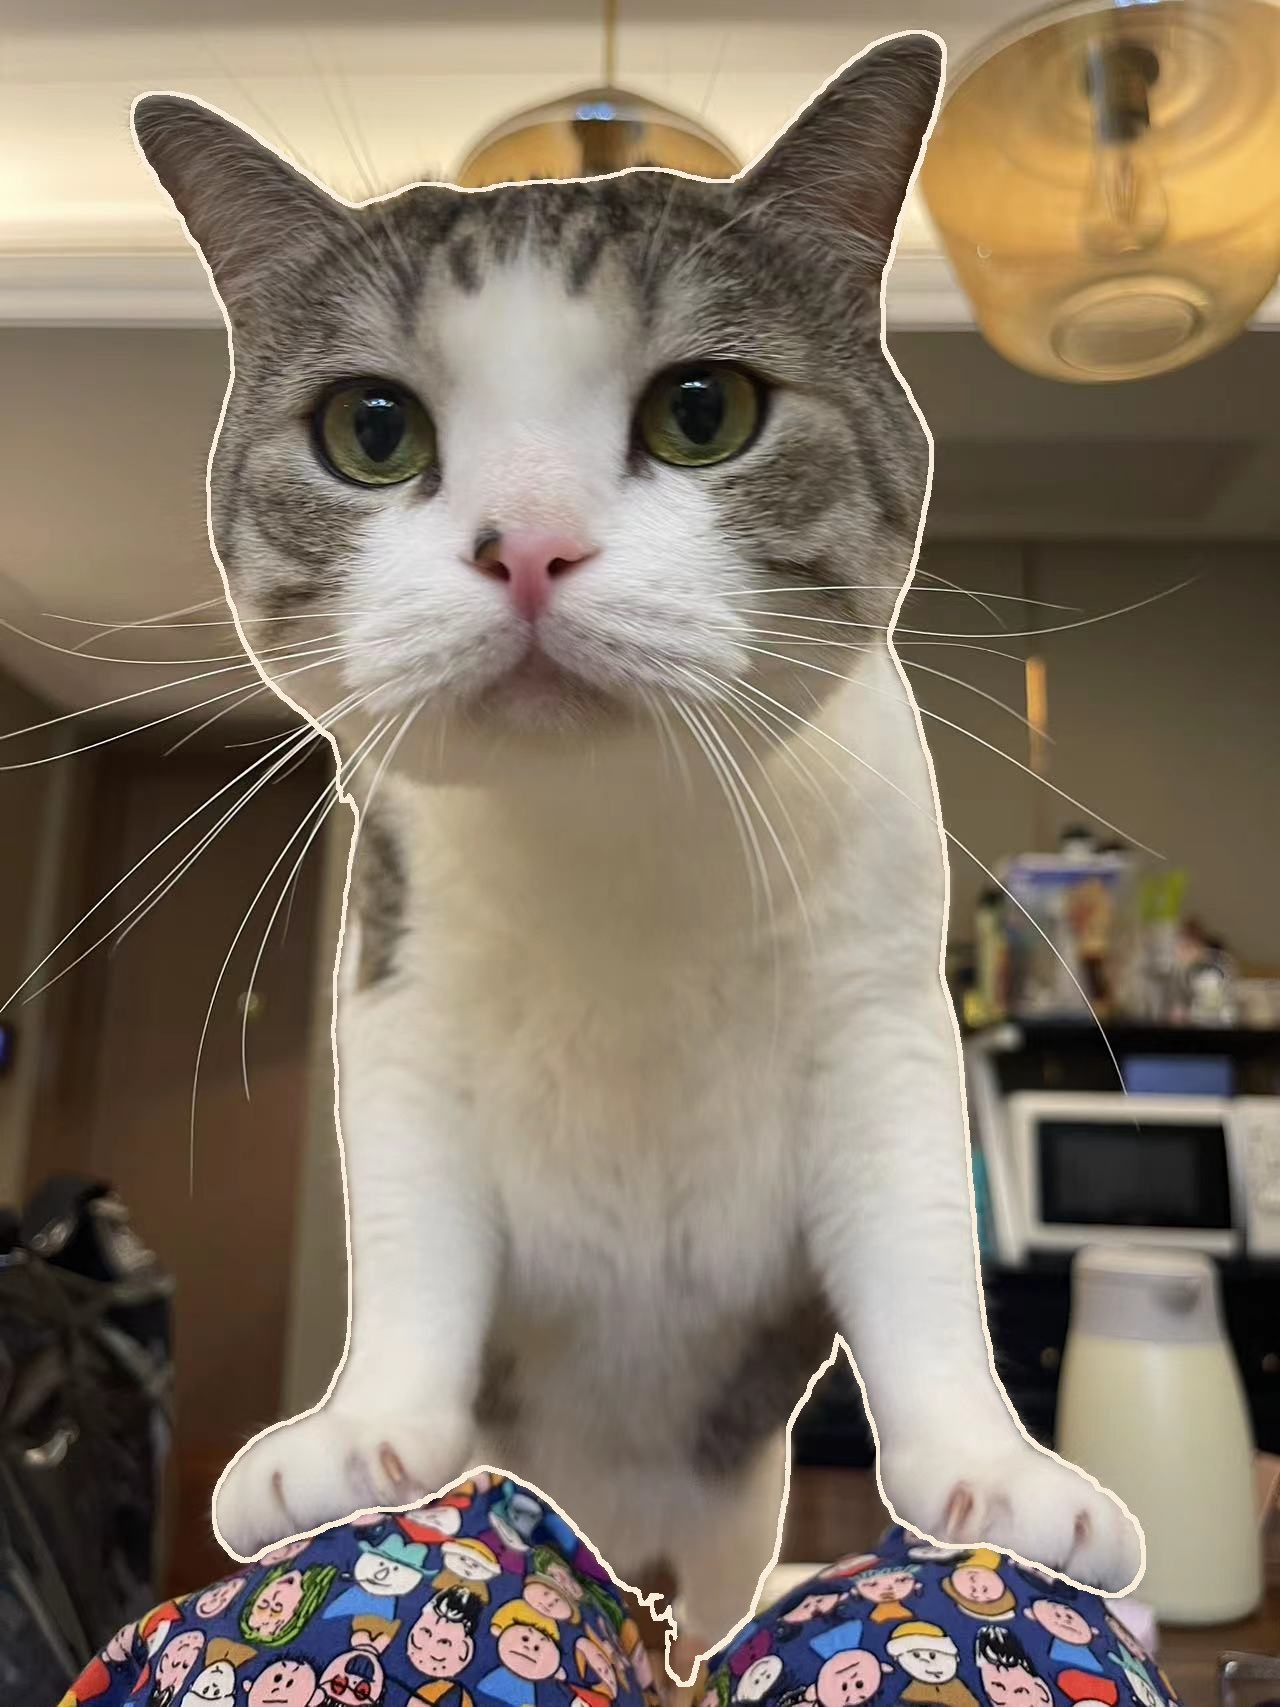

In [15]:
find_part(tbl,img_uuid, 'standing cat')